In [ ]:
! pip install -q kaggle

In [ ]:
!pip install -qU wandb 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.7 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import os
import cv2
from imblearn.over_sampling import SMOTE
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
!pip install timm
from fastkaggle import *
import timm
from fastai.vision.all import *
from google.colab import drive
import wandb
from fastai.callback.wandb import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
wandb.login()

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omarrelsayeed","key":"d97118f1893555df416923cb4c58d125"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d omarrelsayeed/plants-classification

 95% 193M/202M [00:01<00:00, 155MB/s]
100% 202M/202M [00:01<00:00, 148MB/s]


In [ ]:
!unzip /content/plants-classification.zip -d /content/alldataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import albumentations as A

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True



def Album_batchtfms(): 
    #TODO : Remove bad augmentations by trial and error
    return A.Compose([
    A.Resize(height=224, width=224),
    A.RandomSizedCrop( min_max_height=(180,180) , height = 180 , width = 180),
    A.CoarseDropout(p=0.5),
    A.GaussNoise(),
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1), 
    A.ShiftScaleRotate(p=1),
    A.RandomRotate90(p=1),
    A.Rotate(p=1 , limit = 360 , crop_border = True)
])
    
def Album_itemTfms(): 
    return A.Compose([
    A.Resize(height=224, width=224),
    A.RandomSizedCrop( min_max_height=(180,180) , height = 180 , width = 180),
])
    
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def read_images(images_path , desired_size):
  labels = os.listdir(images_path) # dir is your directory path
  train_images=[]
  train_labels=[]
  for label in labels:
      images=get_image_files(images_path , folders=label)
      for img in images:
          train_images.append(cv2.resize(cv2.imread(str(img)),(desired_size, desired_size)))
          train_labels.append(label)
  train_images=np.array(train_images)
  train_labels = np.array(train_labels)
  return train_images , train_labels

def oversample_images( train_images , train_labels , desired_size , Sampling_Algorithm = SMOTE ):
    train_images = train_images.flatten().reshape(train_images.shape[0] , train_images.shape[1] * train_images.shape[1] * 3 )
    oversample = Sampling_Algorithm(random_state = 0)
    X_smote, y_smote = oversample.fit_resample(train_images, train_labels)
    X_smote = X_smote.reshape((X_smote.shape[0] , desired_size , desired_size , 3))
    print("Done Resampling !")
    return X_smote , y_smote

def make_dataloaders_from_numpy_data( image , label , Album = False , bs = 64 ):
    def pass_index(idx):
        return idx

    def get_x(i):
        # NOTE: This is a grayscale image that appears to just work with a network expecting RGB.
        # I suspect this is due to tensor broadcasting rules.
        return image[i]

    def get_y(i):
        return label[i]
    if Album : 
        dblock = DataBlock((ImageBlock,CategoryBlock),
                get_items=pass_index,
                get_x = get_x,
                get_y=get_y,
                splitter=RandomSplitter(valid_pct=0.40),
                item_tfms=[AlbumentationsTransform(Album_itemTfms())],
                batch_tfms = AlbumentationsTransform(Album_batchtfms()))
    else :
        dblock = DataBlock((ImageBlock,CategoryBlock),
                get_items=pass_index,
                get_x = get_x,
                get_y=get_y,
                splitter=RandomSplitter(valid_pct=0.40),
                item_tfms=[Resize((124 , 124) , method = "squish")],
                batch_tfms = [*aug_transforms(
                   size = (224 , 224),
                   max_rotate = 360,
                   flip_vert = True, 
                   min_scale = 0.75, 
                   max_warp=0   )])
        
    num_images = image.shape[0]
    dls = dblock.dataloaders(list(range(num_images)) , bs=bs )

    return dls

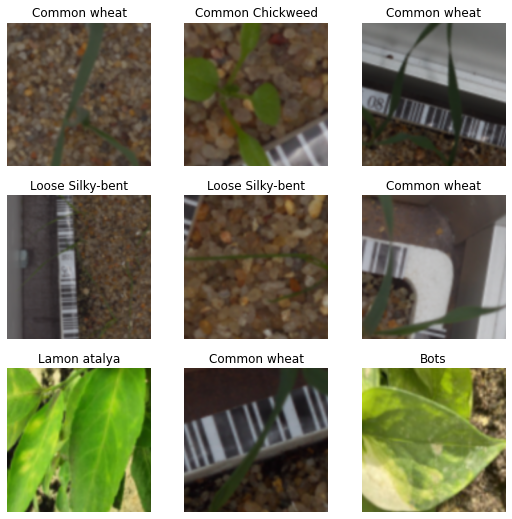

In [ ]:
ALBUM = False
OVERSAMPLE = False
Sampling_Algorithm = SMOTE
image_train_dir = "/content/alldataset/All_dataset"
bs = 128
image_size = 124
SEED = 2023
seed_everything(SEED)
MODEL_NAME=  "convnext_tiny"
if OVERSAMPLE:
  train_images , train_labels = read_images(image_train_dir , desired_size = image_size)
  x_oversampled , y_oversampled = oversample_images(train_images , train_labels , desired_size= image_size , Sampling_Algorithm = Sampling_Algorithm)
  dls = make_dataloaders_from_numpy_data(x_oversampled, y_oversampled , Album = ALBUM)
  dls.show_batch()

if ALBUM  and OVERSAMPLE == False: 

  dls = DataBlock((ImageBlock,CategoryBlock),
                get_items=get_image_files,
                get_y=parent_label,
                splitter=RandomSplitter(valid_pct=0.40),
                item_tfms=[AlbumentationsTransform(Album_itemTfms())],
                batch_tfms = AlbumentationsTransform(Album_batchtfms())).dataloaders(image_train_dir , bs = bs)

elif ALBUM == False and OVERSAMPLE == False :
  dls = DataBlock((ImageBlock,CategoryBlock),
                get_items=get_image_files,
                get_y=parent_label,
                splitter=RandomSplitter(valid_pct=0.40),
                item_tfms=[Resize((image_size , image_size) , method = "squish")],
                batch_tfms = [*aug_transforms(
                   size = (224 , 224),
                   max_rotate = 360,
                   flip_vert = True, 
                   min_scale = 0.75, 
                   max_warp=0)]).dataloaders(image_train_dir , bs = bs)
                   
dls.show_batch()

In [ ]:
# get list of models that start with se
efficient_nets = [model for model in timm.list_models(pretrained=True) if model.startswith('convnext')]
efficient_nets

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [ ]:
learn = vision_learner( dls , "convnext_tiny" , metrics=[accuracy , 
                                                         Precision(average='macro') ,
                                                         Recall(average='macro') 
                                                         , F1Score(average='macro') 
                                                         , RocAuc()] ,
                       path='.' , 
                       normalize = True , 
                       concat_pool = True ).to_fp16() # try with fp16 and without.

In [ ]:
learn.lr_find( suggest_funcs=(minimum , steep , valley, slide) )

In [ ]:
cbs = [  
         EarlyStoppingCallback(monitor = "accuracy" , patience = 3 , min_delta = 0.1)  , 
         MixUp(alpha = 0.3) ,
         CutMix(0.3) , 
         SaveModelCallback(monitor = "accuracy" , at_end = True),
         WandbCallback(log_model = True , model_name = MODEL_NAME ,seed = SEED )
      ]

learn.fine_tune( 1 , 0.01 )

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.880590,0.545422,0.824572,0.851189,0.820198,0.824531,0.994921,01:52


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time


OutOfMemoryError: ignored

In [ ]:
doc(SaveModelCallback)

SaveModelCallback(monitor='valid_loss', comp=None, min_delta=0.0, fname='model', every_epoch=False, at_end=False, with_opt=False, reset_on_fit=True)
A `TrackerCallback` that saves the model's best during training and loads it at the end.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
learn.fine_tune( 5 , 0.001 )

In [ ]:
learn.export("/content/drive/MyDrive/working_models_new/convnext_tiny_small_size_all_dataset.pkl")

In [ ]:
ss = pd.read_csv("/content/plant-seedlings-classification/sample_submission.csv")
tst_files = get_image_files("/content/plant-seedlings-classification/test").sorted()
tst_dl = dls.test_dl(tst_files)
probs , _ , idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
ss['label'] = results
ss.drop('species' , inplace = True , axis=1)
ss.rename({"label" : "species"} , axis=1 , inplace = True)
ss.to_csv('subm.csv', index=False)
!head subm.csv

file,species
0021e90e4.png,Small-flowered Cranesbill
003d61042.png,Fat Hen
007b3da8b.png,Sugar beet
0086a6340.png,Common Chickweed
00c47e980.png,Sugar beet
00d090cde.png,Black-grass
00ef713a8.png,Common Chickweed
01291174f.png,Fat Hen
026716f9b.png,Loose Silky-bent


In [ ]:
#TTA
tst_dl = dls.test_dl(tst_files)
tta_preds , _ = learn.tta(dl=tst_dl)
r = pd.Series(tta_preds.argmax(axis=1).numpy(), name="idxs").map(mapping)
ss['label'] = r
ss.drop('species' , inplace = True , axis=1)
ss.rename({"label" : "species"} , axis=1 , inplace = True)
ss.to_csv('subm2.csv', index=False)
!head subm2.csv

file,species
0021e90e4.png,Small-flowered Cranesbill
003d61042.png,Fat Hen
007b3da8b.png,Sugar beet
0086a6340.png,Common Chickweed
00c47e980.png,Sugar beet
00d090cde.png,Loose Silky-bent
00ef713a8.png,Common Chickweed
01291174f.png,Fat Hen
026716f9b.png,Loose Silky-bent


In [ ]:
def convert_model_to_pkl(weights_path , arch_name):
  learn = vision_learner( dls , arch_name , metrics=accuracy , path='.'   ).to_fp16()
  learn.load(weights_path)
  learn.export( "/content/drive/MyDrive/working_models/" + arch_name)
convert_model_to_pkl("/content/drive/MyDrive/agr_models/convnext_tiny" , "convnext_tiny")

In [ ]:
ss = pd.read_csv("/content/plant-seedlings-classification/sample_submission.csv")
tst_files = get_image_files("/content/plant-seedlings-classification/test").sorted()
tst_dl = dls.test_dl(tst_files).to("cuda")

def load_and_predict(model_path , tst_dl ):

  m = load_learner(model_path , cpu = False)
  probs , _ , idxs = m.get_preds( dl=tst_dl, with_decoded=True)
  tta_preds , _ = m.tta(dl=tst_dl)
  mapping = dict(enumerate(dls.vocab))
  tta_preds = pd.Series(tta_preds.argmax(axis=1).numpy(), name="idxs").map(mapping)
  results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
  del m , probs , idxs , _
  torch.cuda.empty_cache()
  return results , tta_preds
  
results , _ = load_and_predict("/content/drive/MyDrive/working_models/convnext_tiny" , tst_dl)
ss['label'] = results
ss.drop('species' , inplace = True , axis=1)
ss.rename({"label" : "species"} , axis=1 , inplace = True)
ss.to_csv('subm.csv', index=False)
!head subm.csv

In [ ]:
learn.export("/content/drive/MyDrive/working_models/convnext_tiny_final_96.7985")

In [ ]:
learn.predict("/content/89259b72-e894-465e-b61a-83e3bd044f4e.jpg")

('3asfor',
 TensorBase(0),
 TensorBase([9.9999e-01, 2.1387e-10, 2.6721e-10, 1.0195e-08, 7.5184e-08,
             4.6253e-11, 4.8009e-10, 2.8117e-09, 6.1552e-07, 1.8812e-06,
             6.1046e-10, 4.6706e-08, 1.6479e-08, 6.6935e-08, 6.3259e-07,
             5.4092e-09, 1.5558e-09, 3.1746e-07, 3.7657e-08, 5.2625e-10,
             2.2542e-11, 7.1370e-10, 5.6238e-10, 1.0026e-09, 1.3892e-09,
             1.6391e-08, 1.0389e-06, 1.3394e-08, 3.3728e-07, 3.7705e-06,
             3.0511e-08, 1.6567e-07, 2.3265e-09, 2.2770e-09]))

In [ ]:
# End

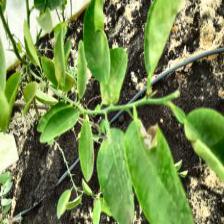

In [ ]:
# to see a specific augmentation
image_train_dir = "/content/alldataset/All_dataset"
items = get_image_files(image_train_dir)
img = PILImage.create(items[0])
aug1 = A.Resize(224 , 224)
aug2 = A.RandomSizedCrop( min_max_height=(224,224) , height = 224 , width = 224) # height and width are the height and width after resizing 
aug2 = A.CLAHE(p=1)
def aug_tfm(img): 
    np_img = np.array(img)
    aug_img = aug1(image=np_img)['image']
    aug_img = aug2(image = aug_img)['image']
    return PILImage.create(aug_img)
aug_tfm(img)

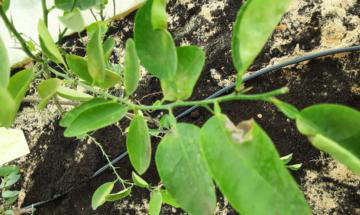

In [ ]:
img